Deep learning techniques are employed for the purpose of differentiating chest X-ray images among patients with Covid-19, viral pneumonia, bacterial pneumonia, and those categorized as normal. This involves the utilization of advanced convolutional neural networks (CNNs) as a powerful tool in the field of medical image analysis. The model is trained on a diverse dataset comprising labeled images from each category, and through this process, it learns to distinguish pathological conditions, contributing to the potential improvement of diagnostic accuracy in healthcare.

# IMPORT LIBRARIES AND DATASET**

In [1]:
%load_ext nb_black
import warnings
warnings.filterwarnings("ignore")

import os
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


<IPython.core.display.Javascript object>

In [2]:
XRay_Directory = 'Dataset'

<IPython.core.display.Javascript object>

In [3]:
import os


<IPython.core.display.Javascript object>

In [4]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

<IPython.core.display.Javascript object>

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Now you can use the ImageDataGenerator class in your code


<IPython.core.display.Javascript object>

In [6]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

<IPython.core.display.Javascript object>

In [7]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 429 images belonging to 4 classes.


<IPython.core.display.Javascript object>

In [8]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 104 images belonging to 4 classes.


<IPython.core.display.Javascript object>

In [9]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)


<IPython.core.display.Javascript object>

In [10]:
train_images.shape

(40, 256, 256, 3)

<IPython.core.display.Javascript object>

In [11]:
train_labels.shape

(40, 4)

<IPython.core.display.Javascript object>

In [12]:
train_labels

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]],

<IPython.core.display.Javascript object>

In [13]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

<IPython.core.display.Javascript object>

 #VISUALIZE DATASET

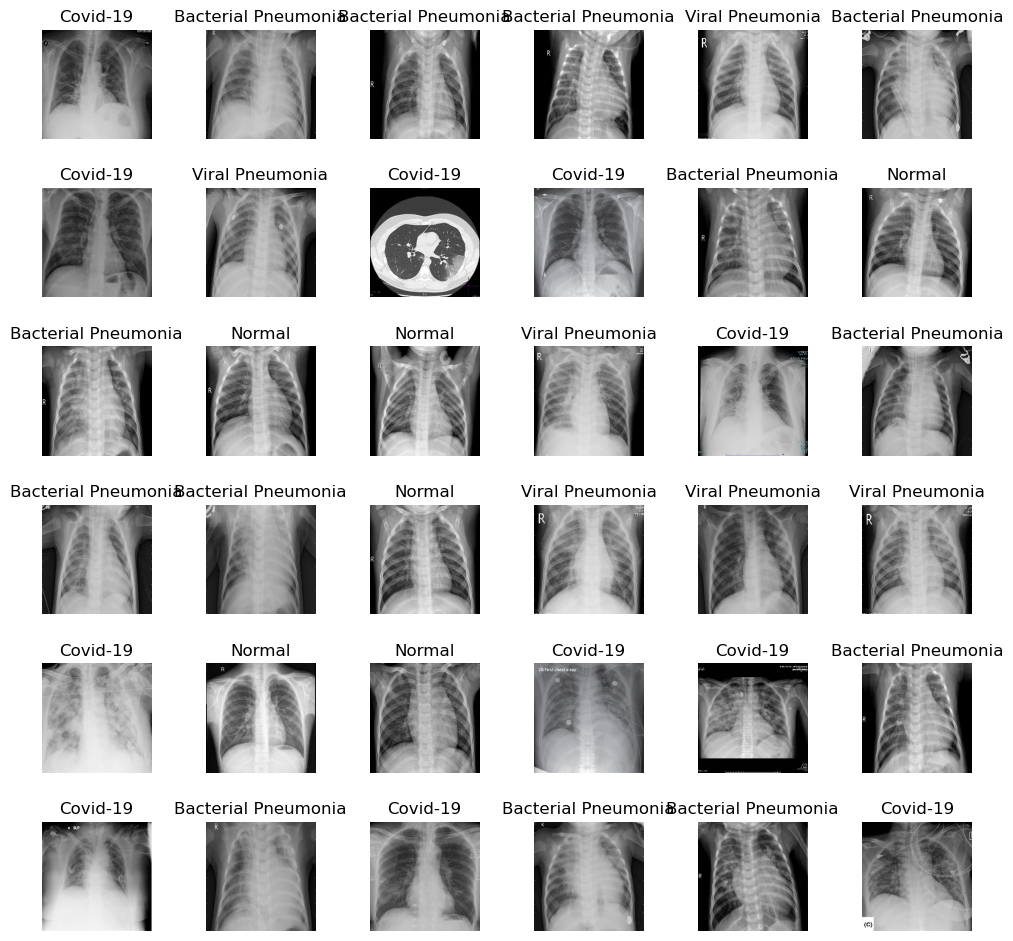

<IPython.core.display.Javascript object>

In [14]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

# IMPORT MODEL WITH PRETRAINED WEIGHTS

In [15]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

<IPython.core.display.Javascript object>

In [16]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

<IPython.core.display.Javascript object>

In [17]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

<IPython.core.display.Javascript object>

# BUILD AND TRAIN DEEP LEARNING MODEL

In [18]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

<IPython.core.display.Javascript object>

In [19]:
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

<IPython.core.display.Javascript object>

In [20]:
from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=1e-4, decay=1e-6), 
              metrics=["accuracy"])


<IPython.core.display.Javascript object>

In [21]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

<IPython.core.display.Javascript object>

In [22]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 429 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


<IPython.core.display.Javascript object>

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.6871
Epoch 1: val_loss improved from inf to 8.27360, saving model to weights.hdf5
107/107 [==============================] - 213s 2s/step - loss: 0.8575 - accuracy: 0.6871 - val_loss: 8.2736 - val_accuracy: 0.2500
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8518
Epoch 2: val_loss did not improve from 8.27360
107/107 [==============================] - 229s 2s/step - loss: 0.4301 - accuracy: 0.8518 - val_loss: 12.1280 - val_accuracy: 0.2500
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9176
Epoch 3: val_loss did not improve from 8.27360
107/107 [==============================] - 215s 2s/step - loss: 0.2383 - accuracy: 0.9176 - val_loss: 8.8735 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9388
Epoch 4: val_loss did not improve from 8.27360
1

<IPython.core.display.Javascript object>

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

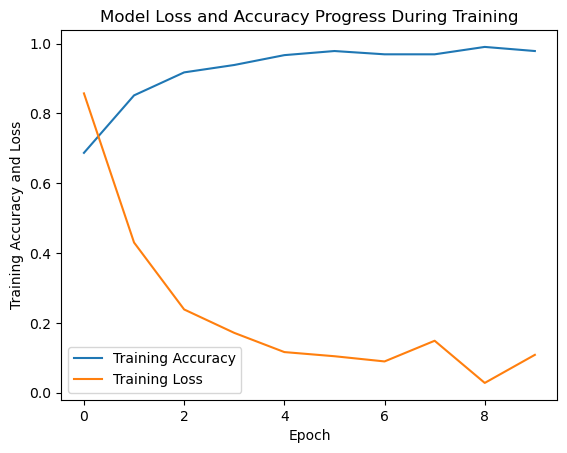

<IPython.core.display.Javascript object>

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

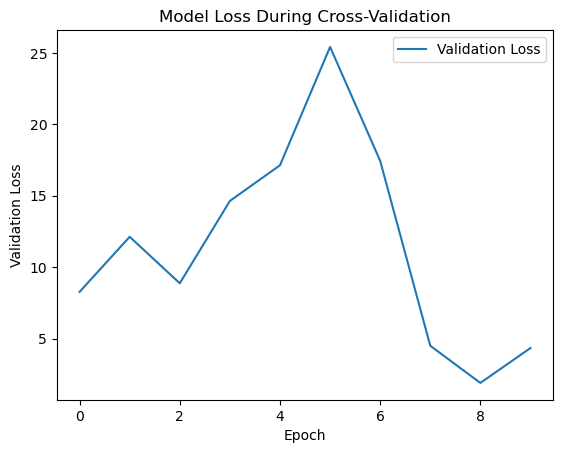

<IPython.core.display.Javascript object>

In [25]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

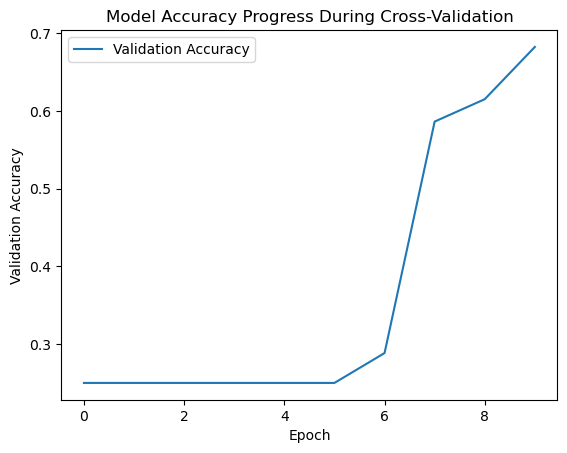

<IPython.core.display.Javascript object>

In [26]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [27]:
test_directory ='Test'


<IPython.core.display.Javascript object>

In [28]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 9s 481ms/step - loss: 3.7875 - accuracy: 0.6750
Accuracy Test : 0.675000011920929


<IPython.core.display.Javascript object>

In [29]:
import cv2 #import open cv


<IPython.core.display.Javascript object>

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 122ms/step


<IPython.core.display.Javascript object>

In [31]:
len(original)

40

<IPython.core.display.Javascript object>

In [32]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.675


<IPython.core.display.Javascript object>

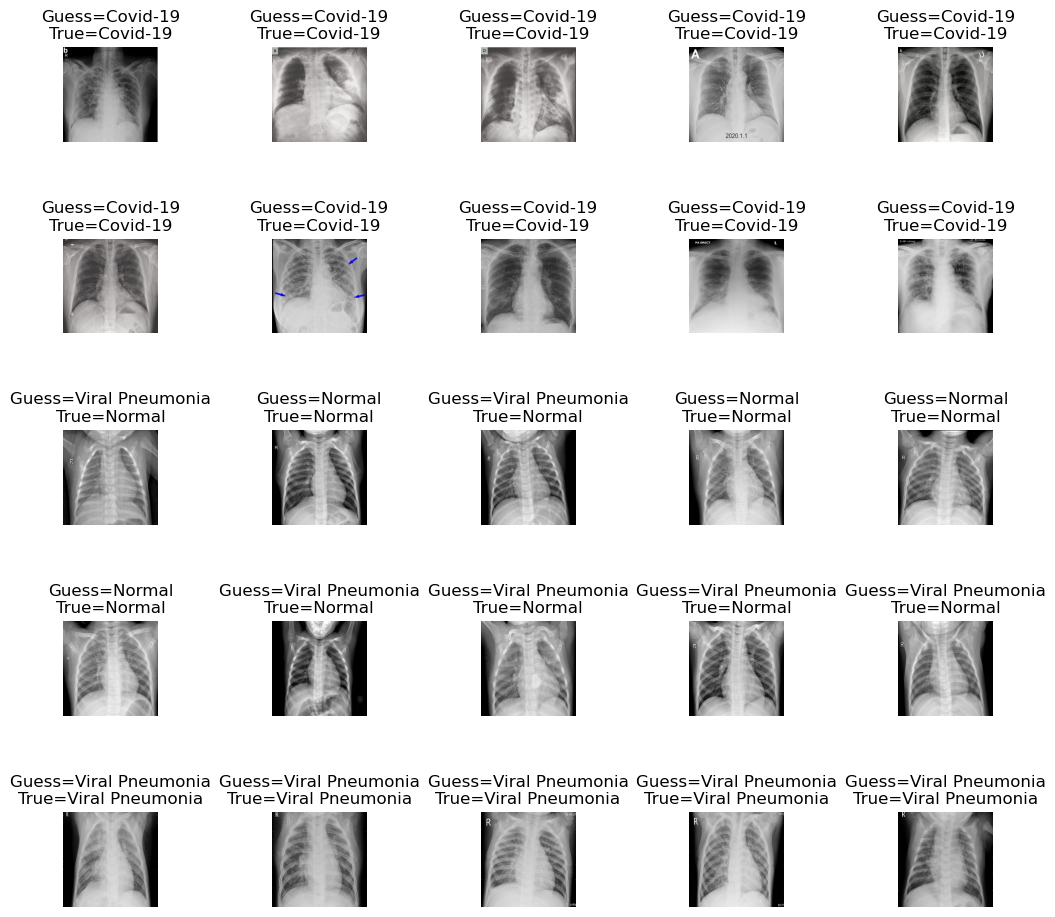

<IPython.core.display.Javascript object>

In [33]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [34]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.80      0.40      0.53        10
           2       0.53      0.80      0.64        10
           3       0.83      0.50      0.62        10

    accuracy                           0.68        40
   macro avg       0.72      0.68      0.66        40
weighted avg       0.72      0.68      0.66        40



<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Confusion_matrix')

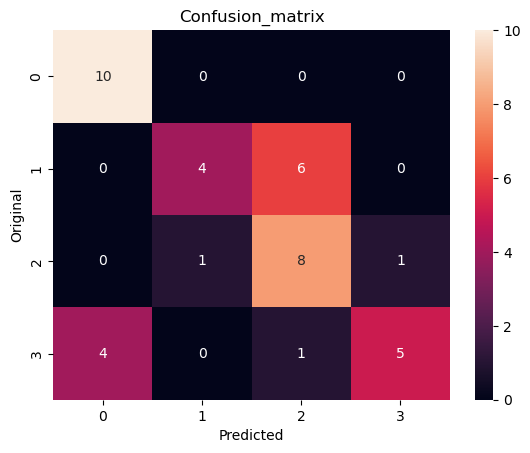

<IPython.core.display.Javascript object>

In [35]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [ ]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}